# Demo 1: Gated Recurrent Unit (GRU)

Gate Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN) that, in certain cases, has advantages over LSTM. GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

This demo we will demo code for construct a GRU model to solve the regression problem:
-   Problem: Predict stock close price of Taiwan Semiconductor Manufacturing Company (TSMC) based on the stock close price of TSMC in previous period
-   Dataset: Stock dataset which is getting from yahoo finance database by using the yfinance package.
-   Library packages:
    -   Yfinance (offers a threaded and Pythonic way to download market data from Yahoo finance)
    -   Pandas (A fast and efficient dataframe object for data manipulation with integrated indexing, reading and writing data between in-memory data structures and different formats: CSV, Microsoft Excel, SQL databases)
    -   Matplotlib (Plot package: visualize data, result,...)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learning (Machine Learning library)

Tasks Outlines:

## 0. Task 0: Preparing dataset
-   Getting the stock dataset of TSMC
-   Exploring about the dataset
-   Normalize or standardlize dataset
-   Divide dataset to trainset and testset
-   Construct data fir GRU model
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a Gated Recurrent Unit model for regression problem
-   Training model on our trainset and applying the model checkpoint during the training to save the best model
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the price of stock
-   Compute the metrics (quantitative measurements)
    -   R2_score, Mean Absolute Error (MAE), Root MAE,...

## Import all packages

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance
from matplotlib import pyplot as plt
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_data_stock_yfinance.ipynb to get detail of demo code for this step

### 0.1. Getting stock data of TSMC with company Code: TSM from 2 years ago.

In [2]:
# Getting stock data of Company Name: TSMC with Company Code: TSM
"""
-   start_date: start time to getting data stock
-   end_data: end time to getting data stock
-   data_source: where to getting data
"""
now = datetime.now()
data_source = 'yahoo'
start_date = now.today() - relativedelta(years  = 2)
end_date = now.today()
print(start_date)
print(end_date)
df_TSM = yfinance.download("TSM",start=start_date,end=end_date)

2021-12-26 23:18:23.610146
2023-12-26 23:18:23.610146
[*********************100%%**********************]  1 of 1 completed


### 0.2. Exploring the data:
See the file Demo_data_stock_yfinance.ipynb for more detail.

In [3]:
# Type of data after getting from yfinance:
print(type(df_TSM))

<class 'pandas.core.frame.DataFrame'>


In [4]:
# Data info:
df_TSM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-12-27 to 2023-12-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [5]:
# Showing most recently five days in our dataframe
df_TSM.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-19,103.239998,103.980003,103.089996,103.870003,103.870003,8498500
2023-12-20,102.699997,103.089996,99.940002,100.040001,100.040001,10814100
2023-12-21,101.300003,102.720001,101.160004,102.550003,102.550003,9068200
2023-12-22,102.930000,103.589996,102.709999,103.150002,103.150002,5566400
2023-12-26,103.610001,104.957497,103.570000,104.809998,104.809998,1305746


### 0.3. Visualize data in stock form.

In [6]:
# Preparing data to plot: range of close open, range of low high, check close >= open for each day
df_TSM["Y_price"] = (df_TSM["Open"] + df_TSM["Close"])/2
df_TSM["Y_error"] = (df_TSM["Open"] - df_TSM["Close"]).abs()/2
df_TSM["HL"] = (df_TSM["High"] + df_TSM["Low"])/2
df_TSM["HL_error"] = (df_TSM["High"] - df_TSM["Low"]).abs()/2
df_TSM["IsPositive"] = df_TSM["Close"] >= df_TSM["Open"]

In [7]:
# We only plot most recently 100 days stock data of TSMC:
data_to_plot = df_TSM.tail(100)

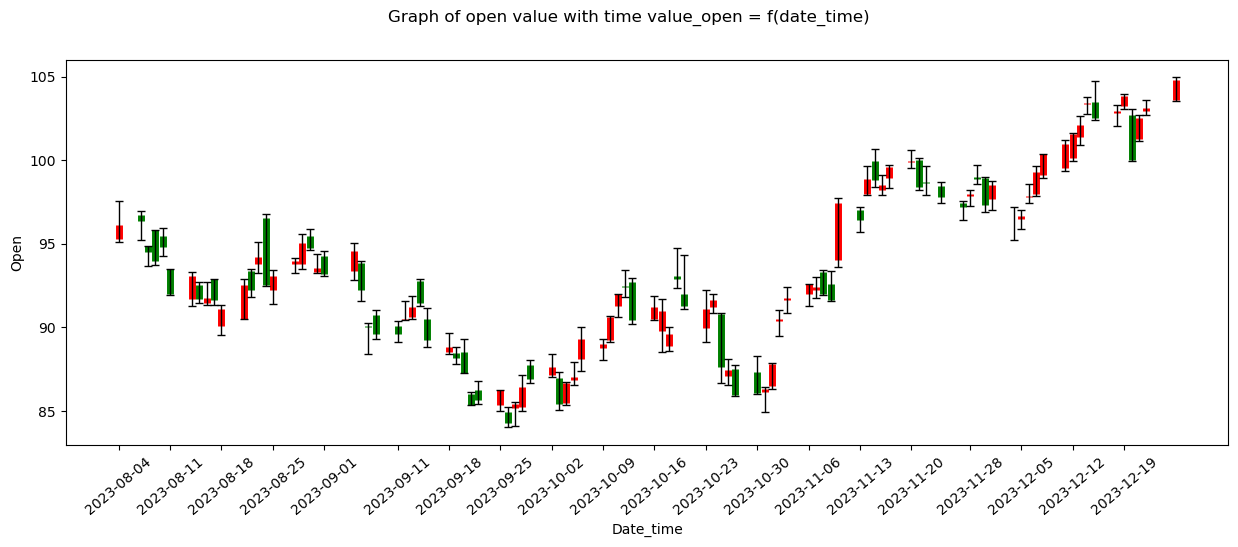

In [8]:
# Visualize data
colors = {True:'red',False:'green'}

fig, ax = plt.subplots(1,1,figsize = (15,5))
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Open"],color='g')
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Close"],color='red')
""" 
The following line of code plot bar range open close, color base on
the comparision of open price and close price
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["Y_price"],
            data_to_plot["Y_error"],
            linewidth = 5, 
            capsize=0,
            ls='none',
            ecolor = data_to_plot['IsPositive'].map(colors))
"""
The following line of code plot black interval with the width = high - low
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["HL"],
            data_to_plot["HL_error"],
            linewidth = 1,
            capsize=3,
            color='k',
            ls='none')

fig.suptitle("Graph of open value with time value_open = f(date_time)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Open")
ax.set_xticks(data_to_plot.index.tolist()[::5]) #Without this it is too dense, with this we only display every after 5 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center
plt.show()

### 0.4. Prepare data for training model:
-   We consider the Close column in our data set as timeseries data
-   Divide data into two parts:
    -   For training: first 400 rows
    -   For testing: start from row 400th
-   Creating a data structure with 60 timesteps and 1 ouput


In [9]:
train_data = df_TSM["Close"][:400].values
X_train = []
y_train = []
for i in range(60,400):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i])
X_train,y_train = np.array(X_train),np.array(y_train)
# Reshaping 
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [10]:
X_train.shape

(340, 60, 1)

## 1. Task 1: Constructing model by using TensorFlow library:
### 1.1. Creating GRU Network model

Model with 3 GRU layers and one output layer


In [11]:
# Define the model GRU
model_GRU = Sequential()
## Adding the first GRU layer and some Dropout regularisation
model_GRU.add(GRU(units = 60,
                        return_sequences=True,
                        input_shape = (X_train.shape[1],1)))
model_GRU.add(Dropout(0.2))
## Adding the second GRU layer and some Dropout regularisation
model_GRU.add(GRU(units=50,
                        return_sequences=True))
model_GRU.add(Dropout(0.2))
## Adding the third GRU layer and some Dropout regularisation
model_GRU.add(GRU(units=50))
model_GRU.add(Dropout(0.2))

## Adding the output layer
model_GRU.add(Dense(units=1))

In [12]:
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 60)            11340     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            16800     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

### 1.2. Training model on our trainset and applying the model checkpoint during the training

In [24]:
mc = ModelCheckpoint('model_GRU.h5',
                     monitor = 'loss',
                     mode = 'min',
                     verbose = 1,
                     save_best_only = True)

In [25]:
epochs = 1000
optimizer = keras.optimizers.Adam()
model_GRU.compile(optimizer=optimizer,
                  loss='mean_squared_error')
history = model_GRU.fit(X_train,y_train,
                        epochs = epochs, 
                        batch_size=32,
                        verbose = 2,
                        callbacks = [mc])

Epoch 1/1000



Epoch 1: loss improved from inf to 42.71750, saving model to model_GRU.h5
11/11 - 9s - loss: 42.7175 - 9s/epoch - 850ms/step
Epoch 2/1000

Epoch 2: loss did not improve from 42.71750
11/11 - 1s - loss: 49.0519 - 1s/epoch - 111ms/step
Epoch 3/1000

Epoch 3: loss did not improve from 42.71750
11/11 - 1s - loss: 44.2359 - 1s/epoch - 106ms/step
Epoch 4/1000

Epoch 4: loss did not improve from 42.71750
11/11 - 1s - loss: 42.8676 - 1s/epoch - 110ms/step
Epoch 5/1000

Epoch 5: loss did not improve from 42.71750
11/11 - 1s - loss: 45.9014 - 1s/epoch - 105ms/step
Epoch 6/1000

Epoch 6: loss did not improve from 42.71750
11/11 - 1s - loss: 44.8698 - 1s/epoch - 103ms/step
Epoch 7/1000

Epoch 7: loss did not improve from 42.71750
11/11 - 1s - loss: 53.0015 - 1s/epoch - 106ms/step
Epoch 8/1000

Epoch 8: loss did not improve from 42.71750
11/11 - 1s - loss: 44.2445 - 1s/epoch - 112ms/step
Epoch 9/1000

Epoch 9: loss did not improve from 42.71750
11/11 - 1s - loss: 48.5309 - 1s/epoch - 112ms/step
Ep

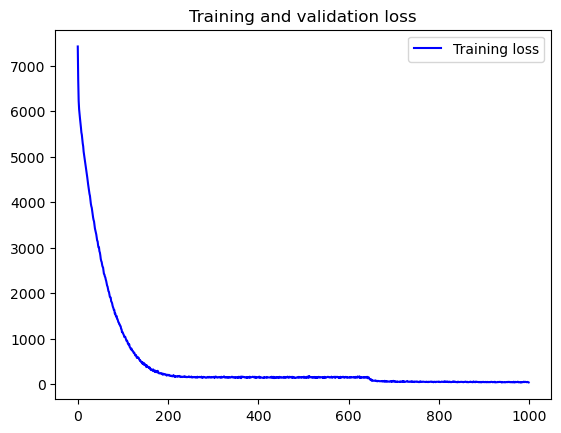

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 2. Task 2: Evaluating the performance of trained model on the testset

### 2.1. Predict the price of stock
Prepare the datatest in structure of timesteps = 60

In [ ]:
# Construct datatest with 60 timesteps
test_data = df_TSM["Close"][400-60:].values
X_test = []
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i])
X_test = np.array(X_test)
X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
print(X_test.shape)

(103, 60, 1)


In [ ]:
# predict the price of stock
pred_test = model_GRU.predict(X_test)

4/4 [==============================] - 2s 39ms/step


In [ ]:
y_test = df_TSM["Close"][400:]

### 2.2. Compute the metrics (quantitative measurements)

In [ ]:
# R2-score:
score = r2_score(y_pred=pred_test,y_true=y_test)
print("The R2 score of our model is: ",score)

The R2 score of our model is:  0.8198189747378096


In [ ]:
# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_test,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

The mean absolute error of our model is:  1.7745713909852852


In [ ]:
#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_test,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The root mean squared error of our model is: 2.1501766670974973


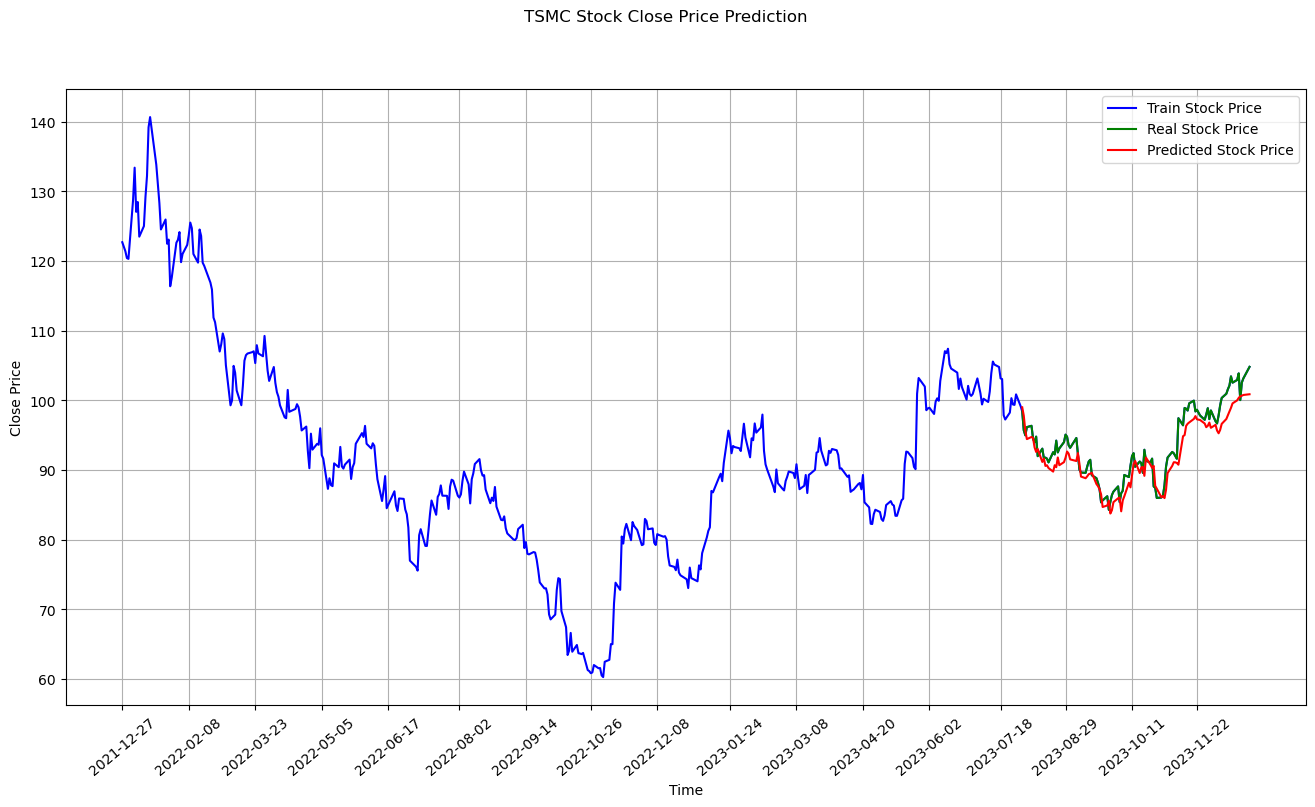

In [ ]:
# Visulize result Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_test[:,0].tolist(), color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()